# Training Unsupervised Models
## 04_unsupervised_model_learning

| Date | User | Change Type | Remarks |  
| ---- | ---- | ----------- | ------- |
| 28/09/2025   | Adrienne | Update | Creating models |
| 05/10/2025 | Adrienne | Update | Created baseline model with KMeans

# Content

* [Introduction](#introduction)

In [53]:

import pandas as pd
import numpy as np

# train test split
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

#unsupervised learning methods
# Feature agglomeration uses agglomerative(or hierarchical) clustering to group similar features, so it has its own dimensionality reduction technique
from sklearn.cluster import KMeans, AgglomerativeClustering, FeatureAgglomeration, DBSCAN
from sklearn.mixture import GaussianMixture

# dimensionality reduction methods
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE

# model selection
from sklearn.model_selection import GridSearchCV

# model scores
from sklearn.metrics import silhouette_score, calinski_harabasz_score

import matplotlib.pyplot as plt

## Load Data

In [118]:
path = "../data/clean"

df_lab_enc = pd.read_pickle(f"{path}/patient_level_lab_enc.pkl")

## Model Development

We will create a baseline model using the label encoded patient level file.  Variations on the model will be added and then performance compared

### Baseline Model - KMeans

Todo: 
- find optimal clusters
- examine most important feature by principal component
 - create graph of clusters with principal components
 - optimize any model inputs

In [123]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_lab_enc)

Dimensionality Reduction

In [124]:
# Perform PCA
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)

# Calculate the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

In [125]:
components = pca.components_
feature_names = df_lab_enc.columns
feature_contributions = pd.DataFrame(components, columns=feature_names)

print(feature_contributions)


     gender       age  number_of_claims  total_value  category_0_enc  \
0  0.001935 -0.002248         -0.017507     0.000256        0.001121   
1  0.000463 -0.004177         -0.009111    -0.001609        0.000879   
2 -0.000353  0.004265          0.021527    -0.000039        0.001454   
3  0.001151 -0.003103         -0.031326     0.004541        0.005607   
4  0.000848  0.002852          0.016940    -0.001058       -0.006412   

   category_1_enc  category_2_enc  category_3_enc  category_4_enc  \
0        0.000349        0.000631       -0.001419       -0.000052   
1        0.000021       -0.001340       -0.001624       -0.003191   
2        0.000549       -0.000028        0.000866        0.001920   
3        0.004763        0.001931        0.003981        0.003754   
4       -0.001057       -0.003380       -0.001419       -0.002197   

   category_5_enc  ...  hcpcs_660_enc  hcpcs_661_enc  hcpcs_662_enc  \
0       -0.000864  ...       0.023862       0.023862       0.023862   
1       -0

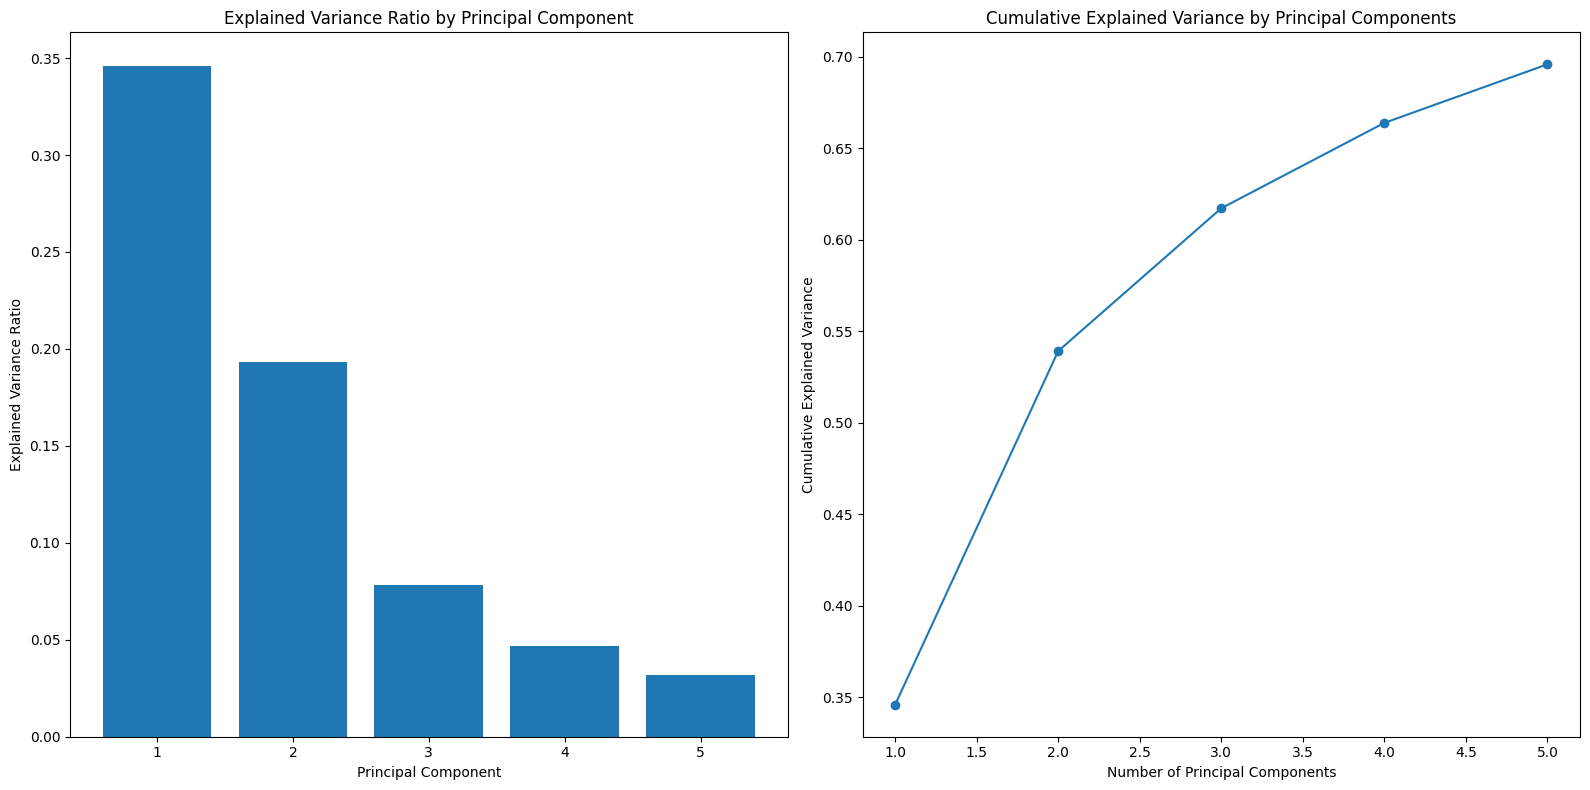

In [126]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

# Plot the explained variance ratio in the first subplot
ax1.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio)
ax1.set_xlabel("Principal Component")
ax1.set_ylabel("Explained Variance Ratio")
ax1.set_title("Explained Variance Ratio by Principal Component")

cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Plot the cumulative explained variance in the second subplot
ax2.plot(
    range(1, len(cumulative_explained_variance) + 1),
    cumulative_explained_variance,
    marker="o",
)
ax2.set_xlabel("Number of Principal Components")
ax2.set_ylabel("Cumulative Explained Variance")
ax2.set_title("Cumulative Explained Variance by Principal Components")

# Display the figure
plt.tight_layout()
plt.show()

In [127]:
# number of components
n_pcs= pca.components_.shape[0]

# get the index of the most important feature on EACH component i.e. largest absolute value
# using LIST COMPREHENSION HERE
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]

initial_feature_names = df_lab_enc.columns

# get the names
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

# using LIST COMPREHENSION HERE AGAIN
dic = {'PC{}'.format(i+1): most_important_names[i] for i in range(n_pcs)}

In [ ]:
# build the dataframe - investigate 
df = pd.DataFrame(sorted(dic.items()))
df

,0,1
0,PC1,description_474_enc
1,PC2,category_175_enc
2,PC3,category_351_enc
3,PC4,category_53_enc
4,PC5,description_461_enc


In [131]:
principal_df = pd.DataFrame(data= X_pca)

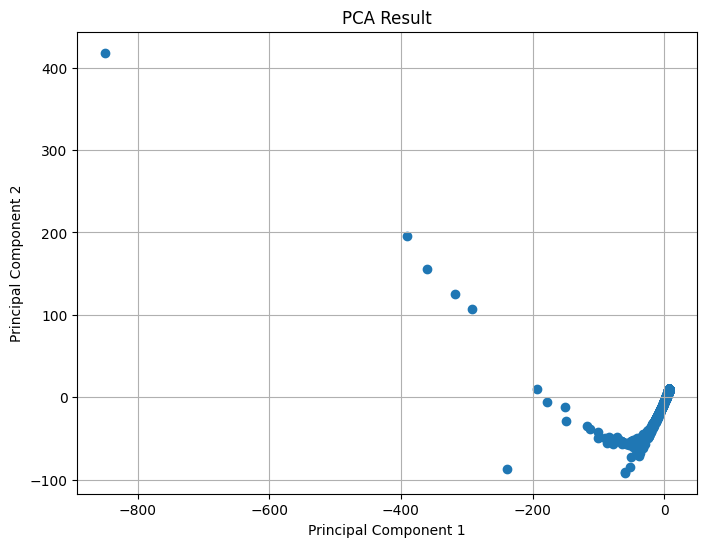

In [ ]:

plt.figure(figsize=(8, 6))
plt.scatter(principal_df[0], principal_df[1])
plt.title('PCA Result')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid()
plt.show()


In [ ]:
# kmeans code
kmeans = KMeans(init = 'random', n_clusters=12, n_init=10, random_state = 0) 
model = kmeans.fit(X_pca) 
model.n_iter_
labels = model.labels_
#print(labels)


[1 1 8 ... 9 7 4]


In [135]:
df_lab_enc['cluster'] = labels

/var/folders/h7/vnb5cqf52l31_n7r6zv3j6z80000gn/T/ipykernel_23972/1552931060.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_lab_enc['cluster'] = labels


In [ ]:
# quick look at cluster values
vals = df_lab_enc['cluster'].value_counts(normalize=True) * 100
pd.DataFrame({
  'cluster': vals
}).head(12)

,cluster
cluster,
1,34.714231
8,16.417338
4,11.660913
7,10.433448
5,8.170311
11,6.290756
2,4.986575
9,3.759110
10,2.224779


In [114]:
principal_df = pd.DataFrame(data= X_pca, columns = ['principal_comp_1', 'principal_comp_2', 'principal_comp_3', 'principal_comp_4', 'principal_comp_5'])

In [115]:
principal_df.head()

,principal_comp_1,principal_comp_2,principal_comp_3,principal_comp_4,principal_comp_5
0,8.216344,-0.524814,2.980144,-9.976194,-1.260475
1,10.899648,6.399896,-3.623889,4.049566,-0.212257
2,11.014609,6.600300,-3.723191,4.556317,-0.184784
3,10.864542,5.930011,-3.005283,2.325768,0.062037
4,11.114533,6.133779,-3.190545,3.142693,0.523086


0      False
1      False
2      False
3      False
4      False
       ...  
143    False
144    False
145    False
146    False
147    False
Name: cluster, Length: 147, dtype: bool


AssertionError: 

<Figure size 640x480 with 0 Axes>

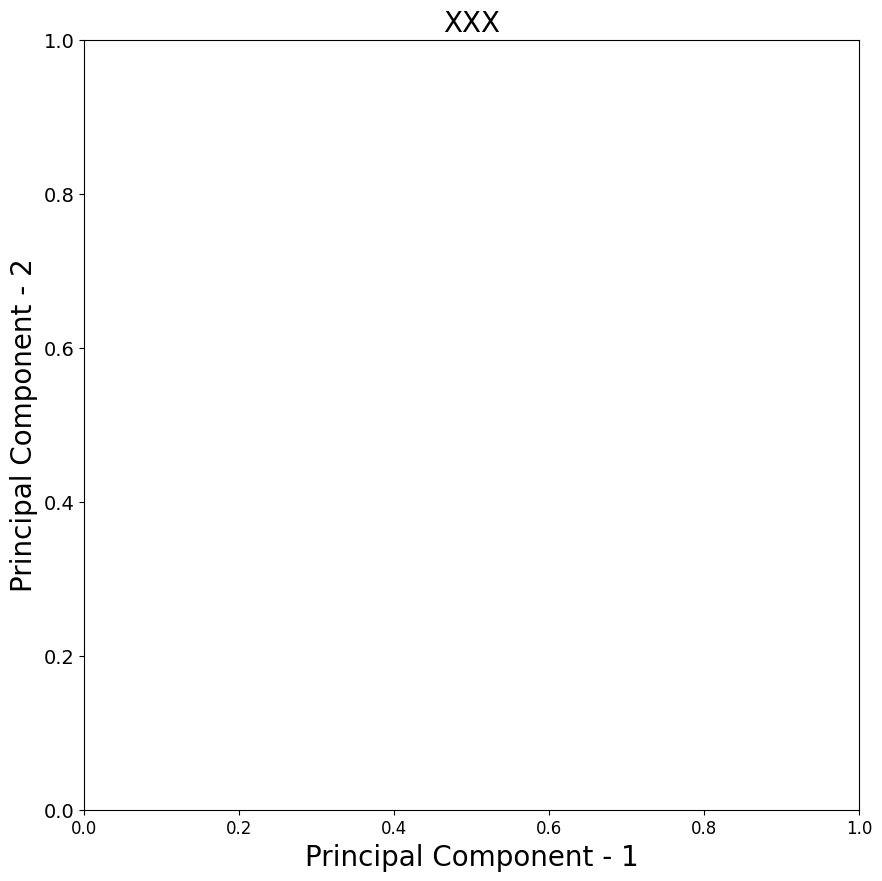

In [117]:
plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component - 1',fontsize=20)
plt.ylabel('Principal Component - 2',fontsize=20)
plt.title("XXX",fontsize=20)
targets = [ 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
#targets = [ 0, 1, 2, 3]
colors = ['r', 'g', 'b', 'y', 'r', 'g', 'b', 'y', 'r', 'g', 'b', 'y']
for target, color in zip(targets,colors):
    indicesToKeep = df_lab_enc['cluster'] == target
    print(indicesToKeep)
    plt.scatter(principal_df.loc[indicesToKeep, 'principal_comp_1']
               , principal_df.loc[indicesToKeep, 'principal_comp_2'], c = color, s = 50)

plt.legend(targets,prop={'size': 15})


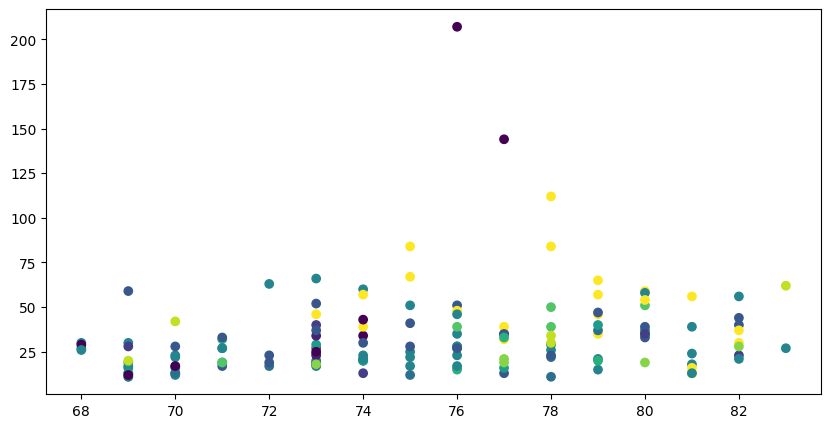

In [41]:
plt.figure(figsize=(10,5))
plt.scatter(x= df_lab_enc.iloc[:, 2], y=df_lab_enc.iloc[:, 3], c= model.labels_)

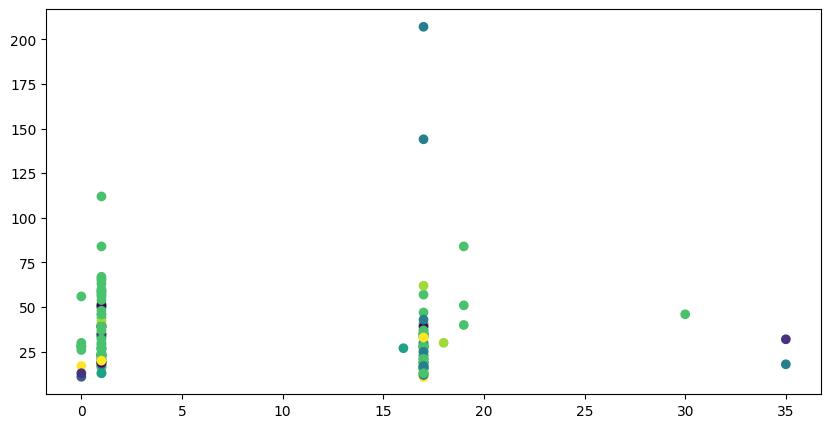

In [36]:
plt.figure(figsize=(10,5))
plt.scatter(x= df_lab_enc.loc[:, 'hcpcs_0_enc'], y=df_lab_enc.loc[:, 'number_of_claims'], c= model.labels_)
# plt.xlabel('Annual Income (k$)')
# plt.ylabel('Spending Score (1-100)')

In [ ]:
# Assign the cluster centers: centroids
centroids = model.cluster_centers_# Assign the columns of centroids: centroids_x, centroids_y
centroids_x = centroids[:,0]
centroids_y = centroids[:,1]# Make a scatter plot of centroids_x and centroids_y
plt.scatter(centroids_x,centroids_y,marker='D',s=50)
plt.show()

In [ ]:
for i, cluster in enumerate(clusters):
    plt.scatter(data[:, 0], data[:, 1], c=cluster, label=f'Cluster {i+1}')
plt.scatter(*centroids, c='red', marker='x', s=200, label='Centroids')
plt.legend()
plt.show()


### Hierarchical Clustering

In [ ]:
# works for AgglomerativeClustering, FeatureAgglomerization and DBScan
from sklearn.cluster import AgglomerativeClustering
agg_clustering = AgglomerativeClustering(n_clusters=3)
labels = agg_clustering.fit_predict(X_train)


### Guassian Mixture

In [ ]:
# GMM code
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=3, random_state=0)
gmm.fit(X)
labels = gmm.predict(X_train)

Model Evaluation

In [ ]:
# elbow method

# works for all sklearn unsupervised model evaluation metrics with DBSCAN
score = silhouette_score(X_train, labels)

Model Selection

In [ ]:
# example grid search

param_grid = {n_components: [2, 5, 8, 10]} # easily add another parameter to this structure

grid_search = GridSearchCV(
    estimator=KMeans(random_state=42, n_init='auto'),
    param_grid=param_grid,
    scoring=silhouette_scorer,
    n_jobs=-1
)

grid_search.fit(X)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

Visualizations:

word cloud 
